# CS229B Project Code
Kyrstyn Ong

Run each of the code blocks in order and follow the directions as to what kind of model/dataset (imputed or missing) is desired.

# 0. Prepare environment; Install packages



In [106]:
!pip install torchdiffeq

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spi

In [107]:
!pip install shap
!pip install lime

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spi

In [108]:
! pip install torchcde

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spi

## Import functions to open data

In [109]:

import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from torch.nn.modules.container import T
from torchdiffeq import odeint
import time


In [110]:
import torchcde

In [111]:
from IPython.lib.pretty import PrettyPrinter
## Added my own function

def torch_bfill(data):
    """ Backward fill for a torch tensor.

    Input: torch tensor input of shape [N, L, C] and will backward along the 2nd (L)
    dimension.
    Output: backward-filled torch tensor output of shape [N, L, C] for NaN values

    References: With reference to torch_ffill defined by XXXX.
    """
    def bfill2d(arr):
        """ 2d Backward fill.
        Input: 2d numpy array
        Output: Backfilled 2d numpy array for Nan values"""
        # Convert array to pandas DataFrame array
        arr_pd = pd.DataFrame(arr)
        # Replace nans with None's in order to use pandas backfill function
        arr_pd = arr_pd.replace({np.nan:None})
        # Backfill tensor with pandas
        backfill_arr_pd = arr_pd.bfill(axis=1)
        # Convert dataframe back into array
        backfill_tensor = np.array(backfill_arr_pd.values)
        out = backfill_tensor
        return out

    data_bfilled = torch.Tensor([bfill2d(x.numpy().T) for x in data]).transpose(1, 2)
    return data_bfilled

## Connect to device

In [112]:
# GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [113]:
print(device)

cpu


# 1. Open training, validation, and test data

## Functions to open dataset

In [114]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
# Scale the feature data from 0 to 1
def get_scaler(scaler):
    """Apply scalar transformation to features"""
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [115]:
# From PhysioNet 2019 Winner "Can I get your signature?"
import numpy as np
import torch
from torch.utils.data import Dataset
class ListDataset(Dataset):
    """Simple dataset for ragged length list-style data.

    If your data consists of tensors of variable lengths inside a list, indexing this dataset will get the corresponding
    list indexed tensor. Useful for deep learning sequential modelling, RNNs, GRUs, etc.
    """
    def __init__(self, data_list, labels):
        self.data_list = data_list
        self.labels = labels

    def __getitem__(self, idx):
        return self.data_list[idx], self.labels[idx]

    def __len__(self):
        return len(self.data_list)

## Open train, val, and test datasets:
Uncomment the cells below "Missing dataset" in order to train the NeuralCDE model on the missing dataset. Otherwise, uncomment the cells below full dataset in order to train the RNN, LSTM, Neural ODE, or NeuralCDE model (trained on the filled in imputed dataset).

These files were prepared and saved using the format_code.ipynb notebook.

Then, run the rest of the cells (scale the data, convert scaled feature matrices to torch tensors).

### Missing dataset

In [116]:
!pwd

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
pwd: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected


In [ ]:
train_data = torch.load('train_val_test_sepsis_datasets/train_data_missing_t_masks_unscaled_20231209.pt')
val_data = torch.load('train_val_test_sepsis_datasets/val_data_missing_t_masks_unscaled_20231209.pt')
test_data = torch.load('train_val_test_sepsis_datasets/test_data_missing_t_masks_unscaled_20231209.pt')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-117-146e5f52903f>", line 1, in <cell line: 1>
    train_data = torch.load('train_val_test_sepsis_datasets/train_data_missing_t_masks_unscaled_20231209.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 986, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 435, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 416, in __init__
    super().__init__(open(name, mode))
OSError: [Errno 107] Transport endpoint is not connected: 'train_val_test_sepsis_datasets/train_data_missing_t_masks_unscaled_20231209.pt'

During handling of the above exception, another exception occurre

In [ ]:
train_labels = torch.load('train_val_test_sepsis_datasets/train_targets_missing_t_masks_unscaled_20231209.pt')
val_labels = torch.load('train_val_test_sepsis_datasets/val_targets_missing_t_masks_unscaled_20231209.pt')
test_labels = torch.load('train_val_test_sepsis_datasets/test_targets_missing_t_masks_unscaled_20231209.pt')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-117-fd2c413559d8>", line 1, in <cell line: 1>
    train_labels = torch.load('train_val_test_sepsis_datasets/train_targets_missing_t_masks_unscaled_20231209.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 986, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 435, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 416, in __init__
    super().__init__(open(name, mode))
OSError: [Errno 107] Transport endpoint is not connected: 'train_val_test_sepsis_datasets/train_targets_missing_t_masks_unscaled_20231209.pt'

During handling of the above exception, another exception

In [117]:
# Check shapes (for missing data F=84 with masks)
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(5497, 336, 84)
torch.Size([5497, 336])
(1077, 336, 84)
torch.Size([1077, 336])
(755, 336, 84)
torch.Size([755, 336])


In [118]:
#Open list of feature names corresponding to the input feature data
feature_name_folder='featurenames_CS229B_project/'
feature_name_file=feature_name_folder+'featlabel_dataset_time_masks_missing_20231209.pt'

In [ ]:
with open(feature_name_file, "rb") as fp:   # Unpickling
  input_feature_labels = pickle.load(fp)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-119-31a2190d8214>", line 1, in <cell line: 1>
    with open(feature_name_file, "rb") as fp:   # Unpickling
OSError: [Errno 107] Transport endpoint is not connected: 'featurenames_CS229B_project/featlabel_dataset_time_masks_missing_20231209.pt'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    retur

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-119-31a2190d8214>", line 1, in <cell line: 1>
    with open(feature_name_file, "rb") as fp:   # Unpickling
OSError: [Errno 107] Transport endpoint is not connected: 'featurenames_CS229B_project/featlabel_dataset_time_masks_missing_20231209.pt'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_node

In [119]:
print(len(input_feature_labels))

84


In [ ]:
#For neuralCDE open missing coeffs
train_coeffs_scaled = torch.load('train_hermitecoeffs_scaled_missing.pt')
val_coeffs_scaled = torch.load('val_hermitecoeffs_scaled_missing.pt')
test_coeffs_scaled = torch.load('test_hermitecoeffs_scaled_missing.pt')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-120-fe0cd1f338eb>", line 2, in <cell line: 2>
    train_coeffs_scaled = torch.load('train_hermitecoeffs_scaled_missing.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 986, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 435, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 416, in __init__
    super().__init__(open(name, mode))
OSError: [Errno 107] Transport endpoint is not connected: 'train_hermitecoeffs_scaled_missing.pt'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-120-fe0cd1f338eb>", line 2, in <cell line: 2>
    train_coeffs_scaled = torch.load('train_hermitecoeffs_scaled_missing.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 986, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 435, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 416, in __init__
    super().__init__(open(name, mode))
OSError: [Errno 107] Transport endpoint is not connected: 'train_hermitecoeffs_scaled_missing.pt'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/

### Full dataset

In [ ]:
train_data = torch.load('train_val_test_sepsis_datasets/train_data_FF_time_unscaled.pt')
val_data = torch.load('train_val_test_sepsis_datasets/val_data_FF_time_unscaled.pt')
test_data = torch.load('train_val_test_sepsis_datasets/test_data_FF_time_unscaled.pt')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-120-00bebeec91fb>", line 1, in <cell line: 1>
    train_data = torch.load('train_val_test_sepsis_datasets/train_data_FF_time_unscaled.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 986, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 435, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 416, in __init__
    super().__init__(open(name, mode))
OSError: [Errno 107] Transport endpoint is not connected: 'train_val_test_sepsis_datasets/train_data_FF_time_unscaled.pt'

During handling of the above exception, another exception occurred:

Traceback (most recent call la

In [ ]:
train_labels = torch.load('train_val_test_sepsis_datasets/train_labels_FF_unscaled.pt')
val_labels = torch.load('train_val_test_sepsis_datasets/val_labels_FF_unscaled.pt')
test_labels = torch.load('train_val_test_sepsis_datasets/test_labels_FF_unscaled.pt')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-120-2589e6dd0a0d>", line 1, in <cell line: 1>
    train_labels = torch.load('train_val_test_sepsis_datasets/train_labels_FF_unscaled.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 986, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 435, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 416, in __init__
    super().__init__(open(name, mode))
OSError: [Errno 107] Transport endpoint is not connected: 'train_val_test_sepsis_datasets/train_labels_FF_unscaled.pt'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-120-2589e6dd0a0d>", line 1, in <cell line: 1>
    train_labels = torch.load('train_val_test_sepsis_datasets/train_labels_FF_unscaled.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 986, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 435, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 416, in __init__
    super().__init__(open(name, mode))
OSError: [Errno 107] Transport endpoint is not connected: 'train_val_test_sepsis_datasets/train_labels_FF_unscaled.pt'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):

In [120]:
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

torch.Size([5497, 336])
torch.Size([755, 336])
torch.Size([1077, 336])


In [121]:
feature_name_folder='featurenames_CS229B_project/'
feature_name_file=feature_name_folder+'fn_dataset_with_time_FF.pt'

In [ ]:
with open(feature_name_file, "rb") as fp:   # Unpickling
  input_feature_labels = pickle.load(fp)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-122-31a2190d8214>", line 1, in <cell line: 1>
    with open(feature_name_file, "rb") as fp:   # Unpickling
OSError: [Errno 107] Transport endpoint is not connected: 'featurenames_CS229B_project/fn_dataset_with_time_FF.pt'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframe

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-122-31a2190d8214>", line 1, in <cell line: 1>
    with open(feature_name_file, "rb") as fp:   # Unpickling
OSError: [Errno 107] Transport endpoint is not connected: 'featurenames_CS229B_project/fn_dataset_with_time_FF.pt'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    if (await self.r

In [122]:
train_data.shape

(5497, 336, 84)

In [123]:
print(input_feature_labels)

['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'hospital', 'AvailMeas', 'Time', 'maskHR', 'maskO2Sat', 'maskTemp', 'maskSBP', 'maskMAP', 'maskDBP', 'maskResp', 'maskEtCO2', 'maskBaseExcess', 'maskHCO3', 'maskFiO2', 'maskpH', 'maskPaCO2', 'maskSaO2', 'maskAST', 'maskBUN', 'maskAlkalinephos', 'maskCalcium', 'maskChloride', 'maskCreatinine', 'maskBilirubin_direct', 'maskTroponinI', 'maskHct', 'maskPTT', 'maskWBC', 'maskFibrinogen', 'maskPlatelets', 'maskAge', 'maskGender', 'maskUnit1', 'maskUnit2', 'maskHospAdmTime', 'maskICULOS', 'maskhospital', 'maskGlucose', 'maskLactate', 'maskMagnesium', 'maskPotassium', 'maskBilirubin_total', 

In [124]:
print(len(input_feature_labels))

84


In [ ]:
# For neuralCDE open full coeffs
train_coeffs_scaled = torch.load('train_hermitecoeffs_scaled_full.pt')
val_coeffs_scaled = torch.load('val_hermitecoeffs_scaled_full.pt')
test_coeffs_scaled = torch.load('test_hermitecoeffs_scaled_full.pt')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-125-e9544c031a3a>", line 2, in <cell line: 2>
    train_coeffs_scaled = torch.load('train_hermitecoeffs_scaled_full.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 986, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 435, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 416, in __init__
    super().__init__(open(name, mode))
OSError: [Errno 107] Transport endpoint is not connected: 'train_hermitecoeffs_scaled_full.pt'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-p

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-125-e9544c031a3a>", line 2, in <cell line: 2>
    train_coeffs_scaled = torch.load('train_hermitecoeffs_scaled_full.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 986, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 435, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 416, in __init__
    super().__init__(open(name, mode))
OSError: [Errno 107] Transport endpoint is not connected: 'train_hermitecoeffs_scaled_full.pt'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-p

## Scale feature input data + set up dataloaders

In [125]:
import pandas as pd

In [126]:
# Scale features
scaler = get_scaler('minmax')
num_instances, num_time_steps, num_features = train_data.shape
train_data_unrolled = np.reshape(train_data, newshape=(-1, num_features))
train_data_scaled_unrolled = scaler.fit_transform(train_data_unrolled)
print(train_data_scaled_unrolled.shape)
train_data_scaled = np.reshape(train_data_scaled_unrolled, newshape=(num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = val_data.shape
val_data_unrolled = np.reshape(val_data, newshape=(-1, num_features))
val_data_scaled_unrolled = scaler.transform(val_data_unrolled)
val_data_scaled = np.reshape(val_data_scaled_unrolled, newshape=(num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = test_data.shape
test_data_unrolled = np.reshape(test_data, newshape=(-1, num_features))
test_data_scaled_unrolled = scaler.transform(test_data_unrolled)
test_data_scaled = np.reshape(test_data_scaled_unrolled, newshape=(num_instances, num_time_steps, num_features))

print(train_data_scaled.shape)
print(val_data_scaled.shape)
print(test_data_scaled.shape)

(1846992, 84)
(5497, 336, 84)
(1077, 336, 84)
(755, 336, 84)


In [127]:
train_data_scaled.shape

(5497, 336, 84)

In [128]:
print(len(train_data_scaled[6][1]))

84


In [129]:
df_vis=pd.DataFrame(train_data_scaled[:,:,-1])

In [130]:
print(input_feature_labels)

['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'hospital', 'AvailMeas', 'Time', 'maskHR', 'maskO2Sat', 'maskTemp', 'maskSBP', 'maskMAP', 'maskDBP', 'maskResp', 'maskEtCO2', 'maskBaseExcess', 'maskHCO3', 'maskFiO2', 'maskpH', 'maskPaCO2', 'maskSaO2', 'maskAST', 'maskBUN', 'maskAlkalinephos', 'maskCalcium', 'maskChloride', 'maskCreatinine', 'maskBilirubin_direct', 'maskTroponinI', 'maskHct', 'maskPTT', 'maskWBC', 'maskFibrinogen', 'maskPlatelets', 'maskAge', 'maskGender', 'maskUnit1', 'maskUnit2', 'maskHospAdmTime', 'maskICULOS', 'maskhospital', 'maskGlucose', 'maskLactate', 'maskMagnesium', 'maskPotassium', 'maskBilirubin_total', 

## Convert train, val, and test scaled feature matrices and labels to torch tensors

In [131]:
# Convert train, val, and test outputs and inputs to torch tensors
train_data_scaled = torch.tensor(train_data_scaled, dtype=torch.float32)
val_data_scaled = torch.tensor(val_data_scaled, dtype=torch.float32)
test_data_scaled = torch.tensor(test_data_scaled, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.int64)
val_labels = torch.tensor(val_labels, dtype=torch.int64)
test_labels = torch.tensor(test_labels, dtype=torch.int64)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [132]:
# For neuralCDE (full) make coefficients
# # train_coeffs_scaled = torchcde.hermite_cubic_coefficients_with_backward_differences(train_data_scaled)
# # val_coeffs_scaled = torchcde.hermite_cubic_coefficients_with_backward_differences(val_data_scaled)
# # test_coeffs_scaled = torchcde.hermite_cubic_coefficients_with_backward_differences(test_data_scaled)

# # torch.save(train_coeffs_scaled,'train_hermitecoeffs_scaled_full.pt')
# # torch.save(val_coeffs_scaled,'val_hermitecoeffs_scaled_full.pt')
# # torch.save(test_coeffs_scaled,'test_hermitecoeffs_scaled_full.pt')

In [133]:
train_coeffs_scaled.shape

torch.Size([5497, 335, 336])

In [134]:
print(train_labels.shape)

torch.Size([5497, 336])


In [135]:
print(train_data_scaled.shape)

torch.Size([5497, 336, 84])


# 2. SET Batch Size and create train, test, and val loader.

The train_coeffloader, val_coeffloader, and test_coeffloader are used only for the NeuralCDE models (which require the hermite polynomial coefficient input).

In [136]:
batch_size =64

## Dataloader conversion

In [137]:
# Dataset
train_ds = ListDataset(train_data_scaled, train_labels)
val_ds = ListDataset(val_data_scaled, val_labels)
test_ds = ListDataset(test_data_scaled, test_labels)

# Dataloaders..
train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size,shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=batch_size,shuffle=True, drop_last=True)

In [138]:
# Dataset
train_coeffds = ListDataset(train_coeffs_scaled, train_labels)
val_coeffds = ListDataset(val_coeffs_scaled, val_labels)
test_coeffds = ListDataset(test_coeffs_scaled, test_labels)

# Dataloaders..
train_coeffloader = DataLoader(train_coeffds, batch_size=batch_size,shuffle=True, drop_last=True)
val_coeffloader = DataLoader(val_coeffds, batch_size=batch_size,shuffle=True, drop_last=True)
test_coeffloader = DataLoader(test_coeffds, batch_size=batch_size,shuffle=True, drop_last=True)

# Network architectures

## Continuous networks

### Neural ODE

#### Functions

In [53]:
import torch
import torch.nn as nn
from torch.nn.modules.container import T
from torchdiffeq import odeint
import time

#### Network within ODE

In [55]:
class OneLayerLinear(nn.Module):
  """
  Network architecture for simple 2 layer neural network inside ODENet.
  """
  def __init__(self, input_dim, hidden_dim, activation_layer='tanh'):
      super(OneLayerLinear, self).__init__()
      self.input_dim = input_dim
      self.hidden_dim = hidden_dim
      self.activation_layer=activation_layer
      self.fc1 = nn.Linear(input_dim, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, input_dim)
      if self.activation_layer=='ELU':
        self.act = nn.ELU(inplace=True)
      else:
        self.act = nn.Tanh()

  def forward(self,t,x):
      self.nfe +=1
      out = self.fc1(x)
      out= self.act(out)
      out = self.fc2(out)
      return out

In [56]:
class TwoLayerLinear(nn.Module):
  """
  Network architecture for simple 2 layer neural network inside ODENet.
  """
  def __init__(self, input_dim, hidden_dim, hidden_dim2, activation_layer='tanh'):
      super(TwoLayerLinear, self).__init__()
      self.input_dim = input_dim
      self.hidden_dim = hidden_dim
      self.hidden_dim2 = hidden_dim2
      self.activation_layer=activation_layer
      self.fc1 = nn.Linear(input_dim, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, hidden_dim2)
      self.fc3 = nn.Linear(hidden_dim2,input_dim)
      if self.activation_layer=='ELU':
        self.act = nn.ELU(inplace=True)
      else:
        self.act = nn.Tanh()

  def forward(self,t,x):
      self.nfe +=1
      out = self.fc1(x)
      out= self.act(out)
      out = self.fc2(out)
      out = self.act(out)
      out = self.fc3(out)
      return out

In [57]:
class ODENet(nn.Module):
    """
    Neural ODE. This code is taken from the MNIST_ODE example in torchdiff.
    https://github.com/rtqichen/torchdiffeq/.

    Uses ODE solver (dopri5 by default) to yield model output.
    Backpropagation is done with the adjoint method as described in
    https://arxiv.org/abs/1806.07366.

    Parameters
    ----------
    odefunc : nn.Module
        network architecture
    rtol : float
        relative tolerance of ODE solver
    atol : float
        absolute tolerance of ODE solver
    """
    def __init__(self, odefunc, rtol=1e-3, atol=1e-3):
        super(ODENet, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()
        self.rtol = rtol
        self.atol = atol

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=self.rtol, atol=self.atol,method='euler')
        return out[1]


In [58]:
class SimpleODENet(nn.Module):
  """Wrapper function for Neural ODE function"""
    def __init__(self, input_dim, odenet,activation_layer='tanh'):
        super(SimpleODENet, self).__init__()
        self.input_dim = input_dim
        self.odenet = odenet
        self.activation_layer=activation_layer
        if self.activation_layer=='ELU':
          self.act = nn.ELU(inplace=True)
        else:
          self.act = nn.Tanh()
        self.fc1 = nn.Linear(input_dim,2)


    def forward(self,x):
        output = self.odenet(x)
        output = self.fc1(output)
        output = self.act(output)
        return output

    def predict(self,x):
      """Function used to produce outputs for SHAP explainer.
      For the neural ODE, all timesteps may be predicted at once.
      Input: 2D numpy array that needs to be reshaped into 3D input matching
      the input
      Return: Predictions in the form of a numpy array"""
      print('x shape inside predict', x.shape)
      x_torch_reshape = torch.reshape(x, (-1,336,self.input_dim))
      model.eval()
      with torch.no_grad():
        Y_pred = model(x_torch_reshape)
      prob_function = torch.nn.Softmax(dim=1)
      Y_pred_unrolled = torch.reshape(Y_pred, shape=(-1,2))
      logits = prob_function(Y_pred_unrolled)
      preds = torch.argmax(logits, axis=1)
      return preds.cpu().numpy()

### CDE Net

In [59]:
import torch
import math
import torchcde

class CDEFunc(torch.nn.Module):
  """Adapted from the time_classification_example.py in torchcde
  https://github.com/patrick-kidger/torchcde"""
    def __init__(self, input_channels, hidden_channels, hidden2):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        self.linear1 = torch.nn.Linear(hidden_channels, hidden2)
        self.linear2 = torch.nn.Linear(hidden2, input_channels * hidden_channels)

    ######################
    # For most purposes the t argument can probably be ignored; unless you want your CDE to behave differently at
    # different times, which would be unusual. But it's there if you need it!
    ######################
    def forward(self, t, z):
        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.tanh()
        z = self.linear2(z)
        ######################
        # Easy-to-forget gotcha: Best results tend to be obtained by adding a final tanh nonlinearity.
        ######################
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z

In [60]:
######################
# Next, we need to package CDEFunc up into a model that computes the integral.
######################
class NeuralCDE(torch.nn.Module):
    """Adapted from the time_classification_example.py in torchcde
    https://github.com/patrick-kidger/torchcde"""
    def __init__(self, input_channels, hidden_channels, output_channels, hidden2, interpolation="cubic"):
        super(NeuralCDE, self).__init__()

        self.func = CDEFunc(input_channels, hidden_channels, hidden2)
        self.initial = torch.nn.Linear(input_channels, hidden_channels)
        self.readout = torch.nn.Linear(hidden_channels, output_channels)
        self.interpolation = interpolation

    def forward(self, coeffs):
        coeffs = coeffs.to(device)
        if self.interpolation == 'cubic':
            X = torchcde.CubicSpline(coeffs)
        elif self.interpolation == 'linear':
            X = torchcde.LinearInterpolation(coeffs)
        else:
            raise ValueError("Only 'linear' and 'cubic' interpolation methods are implemented.")

        ######################
        # Easy to forget gotcha: Initial hidden state should be a function of the first observation.
        ######################

        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)
        tinitial = X.interval[0]
        tstop = X.interval[1]
        tsteps = int(X.interval[1]-X.interval[0]+1)
        time_int = torch.linspace(tinitial, tstop, steps=tsteps).to(device)
        ######################
        # Actually solve the CDE.
        ######################
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.func,
                              t=time_int,
                              adjoint=False,
                              method='euler',
                              options=dict(step_size=1))
        ######################
        # All values are extracted from cdeint
        # and then apply a linear map.
        ######################
        pred_y = self.readout(z_T
        return pred_y

    def predict(self, coeffs):
        batch_coeffs = torch.tensor(coeffs, dtype=torch.float32).unsqueeze(1)
        model.eval()
        with torch.no_grad():
          pred_y = model(batch_coeffs)[:,-1,:].squeeze(1)
        prob_function = torch.nn.Softmax(dim=1)
        Y_pred_unrolled = torch.reshape(pred_y, shape=(-1,2))
        logits = prob_function(Y_pred_unrolled)
        preds = torch.argmax(logits,axis=1)
        return preds.detach().numpy() #.numpy()

In [61]:
for xs, ys in train_coeffloader:
  xs=xs
xs_example = xs[:,0:1,:]
print(xs_example.shape)

torch.Size([64, 1, 336])


## Discrete time networks

### Regular neural network to test training/upate functions

In [62]:
class NeuralNetwork(nn.Module):
    def __init__(self,hidden_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def predict(self, X_test):
      # x is a numpy and return is numpy for SHAP explainer
      x_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
      model.eval()
      with torch.no_grad():
        Y_pred = model(x_torch)# .squeeze(1)
        val, indices = torch.max(Y_pred, 1)
      indices_off_gpu = indices.detach()
      return indices_off_gpu.cpu().numpy()

### RNN

In [63]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """Inputs:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(RNNModel, self).__init__()
        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, nonlinearity='tanh',batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()
        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach()) #.detach()
        # outputs in the shape of (batch_size, seq_length, hidden_size)
        # Convert the final state to our desired output shape
        #(batch_size, seq_length, output_dim)
        out = self.fc(out)
        return out

    def predict(self, X_test):
      # x is a numpy and return is numpy for SHAP explainer
      x_torch = torch.tensor(X_test, dtype=torch.float32).to(device).unsqueeze(1)
      model.eval()
      with torch.no_grad():
        Y_pred = model(x_torch).squeeze(1)
        val, indices = torch.max(Y_pred,1)
      indices_off_gpu = indices.detach()
      return indices_off_gpu.cpu().numpy()

### LSTM

In [64]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """Inputs:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(LSTMModel, self).__init__()
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim
        # Defining the number of layers and the nodes in each layer
        # LSTM layers
        self.lstm = torch.nn.LSTM(
            input_size=input_dim, hidden_size=hidden_dim, num_layers=layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Outputs in the shape of (batch_size, seq_length, hidden_size)
        # Convert the final state to our desired output shape (batch_size, seqlen, output_dim)
        out = self.fc(out)

        return out

    def predict(self, X_test):
      # x is a numpy and return is numpy for SHAP explainer
      x_torch = torch.tensor(X_test, dtype=torch.float32).to(device).unsqueeze(1)
      model.eval()
      with torch.no_grad():
        Y_pred = model(x_torch).squeeze(1)
        val, indices = torch.max(Y_pred,1)
      indices_off_gpu = indices.detach()
      return indices_off_gpu.cpu().numpy()

# 3. Set hyperparameters and define models for training

Run the following block defining the learning rate, num_epochs, and criterion.

Then run one of the sub-code blocks corresponding to model of interest (RNN, LSTM, NeuralODE, or CDE models).

In [66]:
learning_rate = 1e-3
num_epochs= 50
criterion = nn.CrossEntropyLoss()

#### RNN model

Set dropout probability = 0 for 1 layer RNN model or 0.5 for 2 layer RNNs.

In [ ]:
model = RNNModel(input_dim=43, hidden_dim=16, layer_dim=1, output_dim=2,dropout_prob=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


#### LSTM Model

Set dropout probability = 0 for 1 layer LSTM models or 0.5 for 2 layers.

In [ ]:
model = LSTMModel(input_dim=43, hidden_dim=16, layer_dim=1, output_dim=2,dropout_prob=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #,betas=(0.9,0.1)

#### Neural ODE

Run the ODENet with either a TwoLayerLinear or a OneLayerLinear network approximating the derivative dX/dt.

In [ ]:
model = SimpleODENet(43, ODENet(TwoLayerLinear(43,16,16,'tanh'), rtol=1e-3, atol=1e-3),activation_layer='tanh')
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

NameError: ignored

#### CDE Net

For training on the imputed data, set input_channels=43 (number of features).

For training on the missing dataset, set input_channels = 84 (number of features + masks for features containing missing values).

In [67]:
model = NeuralCDE(input_channels=84, hidden_channels=8, output_channels=2, hidden2=4)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# Training functions (same for all models)

In [69]:
def update(model, loss_fn, optimizer, x,y):
  model.train()
  optimizer.zero_grad()
  outputs = model(x.float()).to(device)
  num_samples, num_ts,num_classes = outputs.shape
  outputs_reshaped = torch.reshape(outputs, shape=(-1, num_classes))
  ytrue_reshaped = torch.reshape(y, shape=(-1,))
  #Compute loss
  loss = loss_fn(outputs_reshaped, ytrue_reshaped)
  loss.backward(retain_graph=True)
  optimizer.step()
  return loss.item()

In [70]:
def train(model, criterion, optimizer, train_loader, val_loader, batch_size, num_epochs):
  train_losses,val_losses = [],[]
  train_acc, val_acc = [],[]
  model.train()

  for epoch in range(num_epochs):
      print(f'Training epoch number {epoch}')
      batch_losses,batch_train_acc = [],[]
      for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Apply model to dataset
        yhat_train = model(x_batch)
        prob_function = torch.nn.Softmax(dim=1)
        prob = prob_function(yhat_train.squeeze(1))
        num_samples, num_ts, num_classes = yhat_train.shape
        yhat_train_unrolled = torch.reshape(yhat_train, shape=(-1, num_classes))
        _ , indices = torch.max(yhat_train_unrolled, 1)

        ytrue_unrolled = torch.reshape(y_batch, shape=(-1,))
        acc = float(torch.sum(indices==ytrue_unrolled)/len(ytrue_unrolled))
        batch_train_acc.append(acc)

        #Calculate loss
        loss = update(model.to(device), criterion, optimizer, x_batch, y_batch)
        batch_losses.append(loss)

      training_loss = np.mean(batch_losses)
      train_losses.append(training_loss)
      training_accuracy = np.mean(batch_train_acc)
      train_acc.append(training_accuracy)

      with torch.no_grad():
        batch_val_losses, batch_val_acc = [],[]
        for x_val, y_val in val_loader:
          x_val = x_val.to(device)
          y_val = y_val.to(device)
          model.eval()
          yhat = model(x_val.float())
          num_samples, num_ts, num_classes = yhat.shape
          yhat_unrolled = torch.reshape(yhat, shape=(-1, num_classes))
          yval_unrolled = torch.reshape(y_val, shape=(-1,))

          # Get val accuracy
          prob_function = torch.nn.Softmax(dim=1)
          prob = prob_function(yhat.squeeze(1))
          num_samples, num_ts, num_classes = yhat.shape
          yhat_val_unrolled = torch.reshape(yhat, shape=(-1, num_classes))
          val, indices = torch.max(yhat_val_unrolled, 1)

          vacc = float(torch.sum(indices==yval_unrolled)/len(yval_unrolled))
          batch_val_acc.append(vacc)

          #Compute loss
          val_loss = criterion(yhat_unrolled, yval_unrolled).item()
          batch_val_losses.append(val_loss)

        validation_loss = np.mean(batch_val_losses)
        val_losses.append(validation_loss)

        validation_accuracy = np.mean(batch_val_acc)
        val_acc.append(validation_accuracy)


      if (epoch + 1) % 5 == 0:
          print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}')
          print(f'Epoch [{epoch + 1}/{num_epochs}], Train accuracy: {training_accuracy:.4f}\t Validation accuracy: {validation_accuracy:.4f}')
  return train_losses, val_losses, train_acc, val_acc

## For neuralCDE

In [71]:
def update_neuralCDE(model, loss_fn, optimizer, xb, yb):
    """
    Calculate loss and update weights if training.
    """
    optimizer.zero_grad()
    outputs = model(xb.float())
    outputs_unrolled  = torch.reshape(outputs, shape=(-1,2))
    yb_unrolled = torch.reshape(yb, (-1,)).long()
    loss = loss_fn(outputs_unrolled, yb_unrolled)
    loss.backward(retain_graph=True)
    optimizer.step()
    return loss.item(), len(xb)

In [72]:
def train_neuralCDE(model, loss_fn, optimizer, train_loader, val_loader, batch_size, num_epochs):
  train_losses, val_losses, train_acc, val_acc = [],[],[],[]
  for epoch in range(num_epochs):
    print(f"Training... epoch {epoch + 1}")
    batch_losses, batch_train_acc = [],[]
    model.train() #Set model to training mode
    batch_count=0
    for xb,yb in train_loader:
      coeffs=xb.to(device)
      coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(coeffs).to(device)
      # Calculate accuracy
      yb_unrolled = torch.reshape(yb, (-1,))
      model_output = model(coeffs.float())
      model_output_unrolled  = torch.reshape(model_output, shape=(-1,2))
      prob_function = torch.nn.Softmax(dim=1)
      logits = prob_function(model_output_unrolled)
      preds = torch.argmax(logits, axis=1)

      acc = float(torch.sum(preds == yb_unrolled)/len(yb_unrolled))
      batch_train_acc.append(acc)

      # Calculate loss
      loss, len_xb = update_neuralCDE(model.to(device), loss_fn, optimizer, coeffs, yb.to(device))
      batch_losses.append(loss)

    training_loss = np.mean(batch_losses)
    train_losses.append(training_loss)
    training_accuracy = np.mean(batch_train_acc)
    train_acc.append(training_accuracy)

    batch_val_losses, batch_val_acc = [],[]
    for xv, yv in val_loader:
      model.eval()
      yv_unrolled = torch.reshape(yv, (-1,))
      v_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(xv).to(device)
      model_output = model(v_coeffs.float())
      model_output_unrolled  = torch.reshape(model_output, shape=(-1,2))
      prob_function = torch.nn.Softmax(dim=1)
      logits = prob_function(model_output_unrolled)
      preds = torch.argmax(logits, axis=1)

      # Get val accuracy
      v_acc = float(torch.sum(preds == yv_unrolled)/len(yv_unrolled))
      batch_val_acc.append(v_acc)

      # Compute loss
      yv_unrolled = torch.reshape(yv, (-1,)).long()
      val_loss = loss_fn(model_output_unrolled, yv_unrolled).item()
      batch_val_losses.append(val_loss)

    validation_loss = np.mean(batch_val_losses)
    val_losses.append(validation_loss)
    validation_accuracy = np.mean(batch_val_acc)
    val_acc.append(validation_accuracy)

    if (epoch+1) % 1 ==0:
      print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}')
      print(f'Epoch [{epoch + 1}/{num_epochs}], Train accuracy: {training_accuracy:.4f}\t Validation accuracy: {validation_accuracy:.4f}')
  return train_losses, val_losses, train_acc, val_acc

## For discrete time neural networks

# 4. Train model.

Run the appropriate sub-block of code below corresponding the RNN/LSTM/NeuralODE (which are all trained using the train_loader and val_loader) or the NeuralCDE model (which is trained with the train_coeffloader and val_coeffloader, which contain the hermite polynomial coefficients for the training and validation scaled data).

Note that the training models are identical for all models so the only difference between these two code blocks in the change in type of train_loader or val_loader.

#### RNN/LSTM/Neural ODE model

In [ ]:
train_losses, val_losses, train_acc, val_acc = train(model.to(device),
                                                     criterion,
                                                     optimizer,
                                                     train_loader,
                                                     val_loader,
                                                     batch_size,
                                                     num_epochs)

Training epoch number 0
Training epoch number 1
Training epoch number 2
Training epoch number 3
Training epoch number 4
Epoch [5/50], Train Loss: 0.5052	 Validation loss: 0.5279
Epoch [5/50], Train accuracy: 0.7579	 Validation accuracy: 0.7338
Training epoch number 5
Training epoch number 6
Training epoch number 7
Training epoch number 8
Training epoch number 9
Epoch [10/50], Train Loss: 0.4961	 Validation loss: 0.5277
Epoch [10/50], Train accuracy: 0.7609	 Validation accuracy: 0.7399
Training epoch number 10
Training epoch number 11
Training epoch number 12
Training epoch number 13
Training epoch number 14
Epoch [15/50], Train Loss: 0.4990	 Validation loss: 0.5107
Epoch [15/50], Train accuracy: 0.7617	 Validation accuracy: 0.7423
Training epoch number 15
Training epoch number 16
Training epoch number 17
Training epoch number 18
Training epoch number 19
Epoch [20/50], Train Loss: 0.4961	 Validation loss: 0.5168
Epoch [20/50], Train accuracy: 0.7553	 Validation accuracy: 0.7426
Training

#### CDENet

In [73]:
train_losses, val_losses, train_acc, val_acc = train(model.to(device),
                                                     criterion,
                                                     optimizer,
                                                     train_coeffloader,
                                                     val_coeffloader,
                                                     batch_size,
                                                     num_epochs)

Training epoch number 0
Training epoch number 1
Training epoch number 2
Training epoch number 3
Training epoch number 4
Epoch [5/30], Train Loss: 0.4907	 Validation loss: 0.5017
Epoch [5/30], Train accuracy: 0.7691	 Validation accuracy: 0.7560
Training epoch number 5
Training epoch number 6
Training epoch number 7
Training epoch number 8
Training epoch number 9
Epoch [10/30], Train Loss: 0.4026	 Validation loss: 0.4157
Epoch [10/30], Train accuracy: 0.8218	 Validation accuracy: 0.8068
Training epoch number 10
Training epoch number 11
Training epoch number 12
Training epoch number 13
Training epoch number 14
Epoch [15/30], Train Loss: 0.3741	 Validation loss: 0.3967
Epoch [15/30], Train accuracy: 0.8383	 Validation accuracy: 0.8243
Training epoch number 15
Training epoch number 16
Training epoch number 17
Training epoch number 18
Training epoch number 19
Epoch [20/30], Train Loss: 0.3544	 Validation loss: 0.3905
Epoch [20/30], Train accuracy: 0.8500	 Validation accuracy: 0.8330
Training

# Visualize training/validation loss and accuracy curves

In [ ]:
print("Model:",model)

print("lr:", learning_rate, "batch size", batch_size)
print('Final train loss:', train_losses[-1:])
print('Final val loss:', val_losses[-1:])

print('Final train acc:', train_acc[-1:])
print('Final val acc:', val_acc[-1:])


model NeuralCDE(
  (func): CDEFunc(
    (linear1): Linear(in_features=4, out_features=2, bias=True)
    (linear2): Linear(in_features=2, out_features=172, bias=True)
  )
  (initial): Linear(in_features=43, out_features=4, bias=True)
  (readout): Linear(in_features=4, out_features=2, bias=True)
)
lr; 0.01 batch size 64
final train loss [0.4470824732499964]
final val loss [0.5246718153357506]
final train acc [0.7934015000567717]
final val acc [0.7564958892762661]
final train prec [0.7934015000567717]
final val acc [0.7564958892762661]


Plot the training and validation loss curves

Text(0.5, 1.0, '')

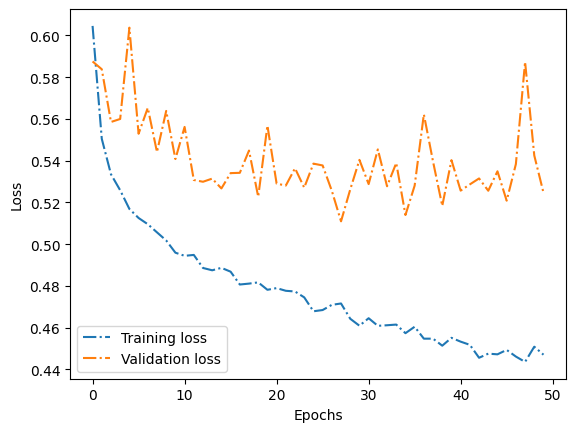

In [ ]:
plt.plot(train_losses,'-.',label='Training loss')
plt.plot(val_losses,'-.',label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('')

Plot the training validation accuracy curves during training

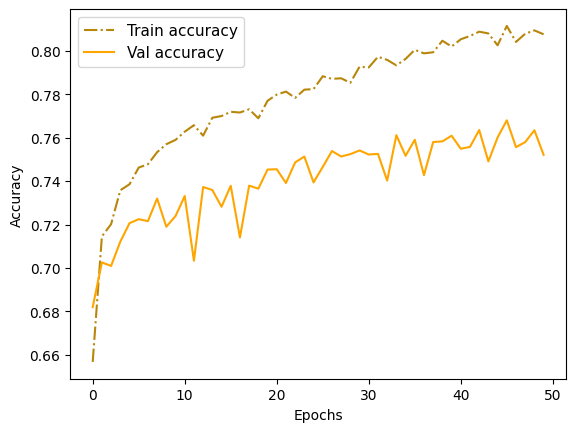

In [ ]:
plt.plot(train_acc,'-.',label='Train accuracy',color='darkgoldenrod')
plt.plot(val_acc,'-',label='Val accuracy',color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best',fontsize=11)


## Save training/ validation accuracy/loss (for plotting later)

Uncomment out these cells and change the name of the files to save the accuracy and loss curves

In [ ]:
# torch.save(train_acc,'results/trainacc_filledCDE42_lr12_GPUex1.pt')
# torch.save(val_acc,'results/valacc_filledCDE42_lr12_GPUex1.pt')
# torch.save(train_losses,'results/trainloss_filledCDE42_lr12_GPUex1.pt')
# torch.save(val_losses,'results/valloss_filledCDE42_lr12_GPUex1.pt')

# 5. Timing/ memory of model during training only

In [ ]:
# From Homework 4
import tracemalloc

def tracemalloc_start():
    tracemalloc.start()

def report():
    current, peak = tracemalloc.get_traced_memory()
    print(f"Current memory usage is {current / 1024 ** 2} MB; Peak was {peak / 1024 ** 2} MB")

def reset():
    tracemalloc.reset_peak()

In [ ]:
# Zero original memory trace to make sure that measurement is accurate.
tracemalloc.clear_traces()
print("Start memory trace:")
report()
tracemalloc.start()
initial_time = time.time()

Start memory trace:
Current memory usage is 0.0 MB; Peak was 0.0 MB


For the NeuralCDE model, change the train_loader to the train_coeffloader.
All other models use the train_loader.

Only the time for the model to train is measured (the validation accuracy/losses are removed since they would increase the measured time)

In [ ]:
batch_losses, batch_train_acc = [],[]
model.train() #Sets model to training mode
batch_count=0
for xb,yb in train_loader: #coeffloader for CDE and loader for all other models
  x_batch = xb.to(device)
  y_batch = yb.to(device)
  #Compute loss
  loss = update(model.to(device), criterion, optimizer, x_batch, y_batch)
curr_time=time.time()
elapsed_time=round((curr_time-initial_time)/60,5)

In [ ]:
report()
print(elapsed_time)

Current memory usage is 0.1391916275024414 MB; Peak was 0.36115264892578125 MB
0.51472


In [ ]:
tracemalloc.clear_traces()

# 6. Evaluation

### Run these code blocks to import necessary classification functions

In [ ]:
def evaluate(model, X_test, Y_test, output_labels):
    """
    Inputs:
        model: A Pytorch Module
        X_test: A batch of inputs of shape (P, T, F= # features)
        Y_test: A batch of ground truth labels of shape (P,T) (integer-valued)
    Outputs:
        acc: A floating point number of the classification accuracy averaged over this batch
    """
    X_test = X_test.to(device)
    print("Xtest shape", X_test.shape)
    Y_test = Y_test.to(device)
    ytrue_unrolled = yval_unrolled = torch.reshape(Y_test, shape=(-1,))
    print("ytrue_unrolled shape", ytrue_unrolled.shape) #reshape to (P*T,)
    model.eval()
    with torch.no_grad():
      Y_pred = model(X_test)
      num_samples, num_ts, num_classes = Y_pred.shape
      yhat_unrolled = torch.reshape(Y_pred, shape=(-1, num_classes)) #reshape to (P*T, F)
      val, indices = torch.max(yhat_unrolled, 1)
      indices_off_gpu = indices.detach()
      indices = indices_off_gpu.cpu()

      y_unrolled_off = ytrue_unrolled.detach()
      y_unrolled_off = y_unrolled_off.cpu()
      acc = float(torch.sum(indices==y_unrolled_off)/len(ytrue_unrolled))
      print('Accuracy', acc)
      predicted_counts = [sum(indices.numpy() == i) for i in range(len(output_labels))]
      print(predicted_counts)
      true_counts = [sum(ytrue_unrolled.cpu().numpy() == i) for i in range(len(output_labels))]
      print(true_counts)
      return acc, predicted_counts, true_counts, indices,ytrue_unrolled

In [ ]:
def get_classification_metrics(y_test_labels, y_predicted_from_model):
  """Calculate the true positive counts,
  true negative counts, false positive counts, and false negative counts
  from the model predictions

  Input: list of actual true labels, list of model predictions
  Output: Counts of true positive, true negative, false positive,
  and false negatives"""
  true_positive,true_negative, false_positive, false_negative = 0,0,0,0
  for idx in range(len(y_test_labels)):
    if y_test_labels[idx] == y_predicted_from_model[idx]:
      if y_predicted_from_model[idx]==1:
        true_positive+=1
      elif y_predicted_from_model[idx]==0:
        true_negative+=1
    elif y_test_labels[idx] != y_predicted_from_model[idx]:
      if y_predicted_from_model[idx]==1:
        false_positive+=1
      elif y_predicted_from_model[idx]==0:
        false_negative+=1
  return true_positive, true_negative, false_positive, false_negative

In [ ]:
def precision(tp,fp):
  """Calculates precision from number of true positives and false positives
  from model predictions"""
  precision_val = tp/(tp+fp)
  return precision_val

def recall(tp,fn):
    """Calculates precision from number of true positives and false negatives
  from model predictions"""
  recall_val = tp/(tp+fn)
  return recall_val

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [ ]:
def plot_true_predicted_labels(species_names, true_counts, predicted_counts,title):
  """"Plot true and predicted counts for classification labels
  (does not take into account the order of the predictions--the timestep where
  certain labels were expected to arise)"""
  fig, ax = plt.subplots()
  width = 0.35
  x = range(len(species_names))

  rects1 = ax.bar(x, true_counts, width, label='True Labels')
  rects2 = ax.bar([i + width for i in x], predicted_counts, width, label='Predicted Labels')

  ax.set_xlabel('Class')
  ax.set_ylabel('Counts')
  ax.set_title(title)
  ax.set_xticks([i + width/2 for i in x])
  ax.set_xticklabels(species_names)
  ax.legend()

  plt.show()

## 6A. Classification metrics

In [ ]:
class_labels = ['Non-septic: 0', 'Septic: 1']

In [ ]:
print(model)

NeuralCDE(
  (func): CDEFunc(
    (linear1): Linear(in_features=4, out_features=2, bias=True)
    (linear2): Linear(in_features=2, out_features=172, bias=True)
  )
  (initial): Linear(in_features=43, out_features=4, bias=True)
  (readout): Linear(in_features=4, out_features=2, bias=True)
)


In [ ]:
#For neuralCDE (using test_coeffs_scaled)
acc, pred_count, true_count, ypredicted,ytrue = evaluate(model, test_coeffs_scaled, test_labels,class_labels)

Xtest shape torch.Size([755, 335, 172])
ytrue_unrolled shape torch.Size([253680])
Accuracy 0.7862740755081177
[184652, 69028]
[168648, 85032]


In [ ]:
# For all models other than NeuralCDE (using test_data_scaled)
#acc, pred_count, true_count, ypredicted,ytrue = evaluate(model, test_data_scaled, test_labels,species_names)

In [ ]:
true_positive, true_negative, false_positive, false_negative = get_classification_metrics(ytrue, ypredicted)

In [ ]:
print('Final test accuracy:', acc)

Final test accuracy: 0.7862740755081177


In [ ]:
print('Precision:', precision(true_positive, false_positive))

print('Recall:', recall(true_positive, false_negative))

Precision: 0.7231992814510054
Recall: 0.5870848621695361


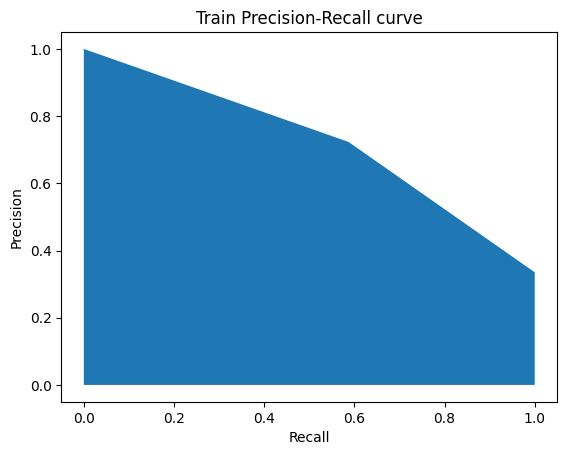

In [ ]:
precision, recall, thresholds = precision_recall_curve(ytrue.cpu(), ypredicted.cpu())
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve");

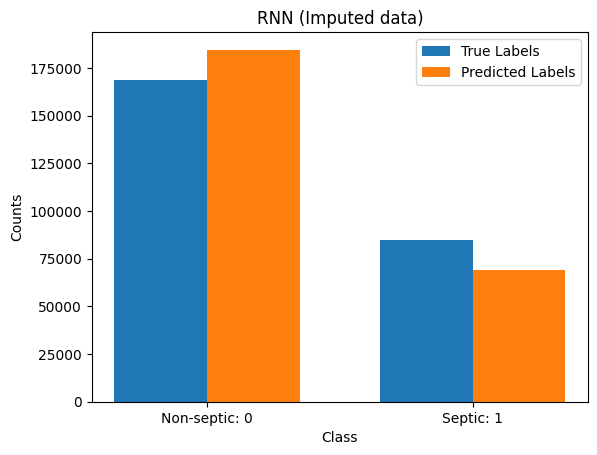

In [ ]:
plot_true_predicted_labels(class_labels, true_count, pred_count,'RNN (Imputed data)')

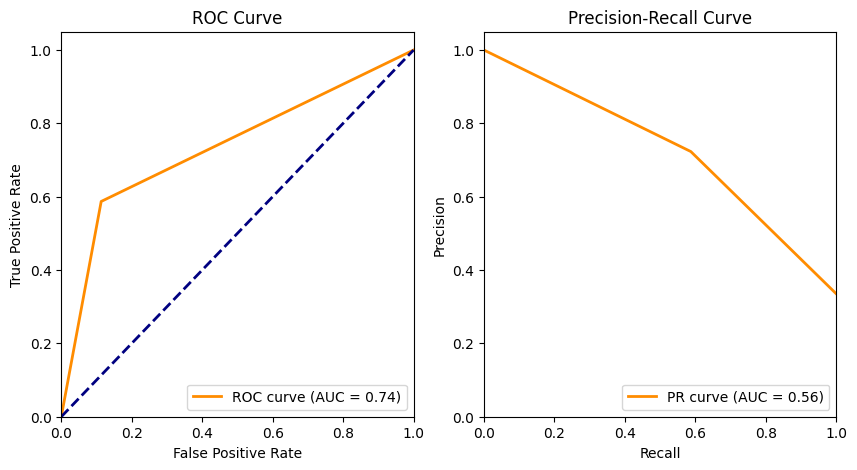

In [ ]:
y_test=ytrue
y_score=ypredicted
# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test.cpu(), y_score.cpu())
roc_auc = auc(fpr, tpr)

In [ ]:
print('Area under the receiver operating curve metric', roc_auc)

ROCAUC metric 0.7368948574402541


In [ ]:
# Calculate the Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test.cpu(), y_score.cpu())
pr_auc = average_precision_score(y_test.cpu(), y_score.cpu())

# Plot the ROC curve
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot the Precision-Recall curve
plt.subplot(1,2,2)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

## 6B. Shapley explainability

In [74]:
import pandas as pd
import shap
print(shap.__version__)

0.44.0


In [75]:
train_coeffs_scaled.shape

torch.Size([5497, 335, 336])

Generate random test and training poitns (subset for all models except for the NeuralODE model, which trains quickly on the entire training and test set)

In [87]:
random_train_indices = torch.randint(low=0, high=5490, size=(150,))
random_test_indices = torch.randint(low=0, high=750, size=(150,))

For Neural CDE use train_coeffs_scaled and test_coeffs_scaled as input.

For all other models use train_data_scaled and test_data scaled.

Note that the last time step is selected in order to compare the explainability values for the final sepsis prediction, but other time indices could be used (from 0 to 336 in second index of the train_data_scaled matrix).

In [88]:
subset_X_train = train_coeffs_scaled[random_train_indices]
print(subset_X_train.shape)
last_step_X_train = subset_X_train[:,-1:,:]
print(last_step_X_train.shape)
subset_X_train_reshaped = torch.reshape(last_step_X_train, shape=(-1,336))
last_step_X_test = test_coeffs_scaled[:,-1:,:][random_test_indices].squeeze(1)
print(last_step_X_test.shape)
last_step_X_test_pd = pd.DataFrame(last_step_X_test)
last_step_X_train.squeeze(1).shape



torch.Size([150, 335, 336])
torch.Size([150, 1, 336])
torch.Size([150, 336])


torch.Size([150, 336])

In [89]:
print(subset_X_train_reshaped.shape)

torch.Size([150, 336])


In [90]:
# Train SHAP explainer on training data
explainer = shap.KernelExplainer(model.predict, np.array(subset_X_train_reshaped))

In [91]:
# Train SHAP explainer on test data
shap_values = explainer.shap_values(np.array(last_step_X_test_pd))


  0%|          | 0/150 [00:00<?, ?it/s]

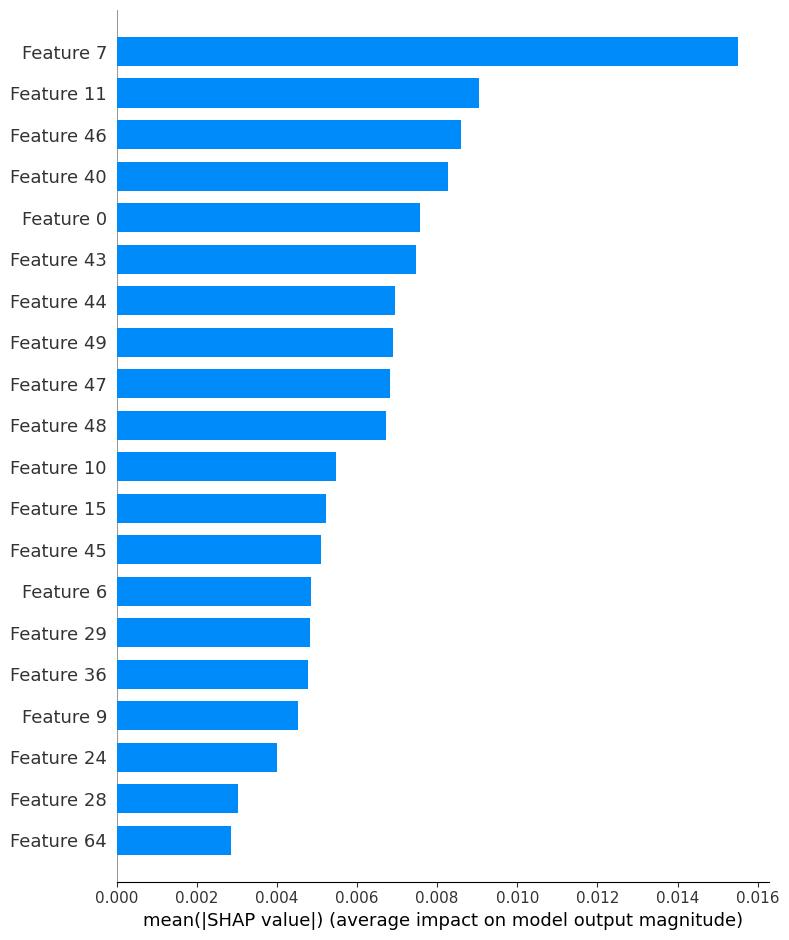

In [92]:
shap.summary_plot(shap_values, plot_type="bar")

In [ ]:
# For RNN, LSTM, and Neural ODE Models display feature labels
shap.summary_plot(shap_values, last_step_X_test,feature_names=input_feature_labels,max_display=30)


For the Neural CDE model, the input feature labels will not work directly as in input to feature_names because there are 4*#features for the hermite coefficients.

Luckily the first F coefficients correspond to the same feature labels (the next F coefficients correspond to the derivative of features with respect to time). Therefore, it is possible to manually print the input_feature_labels corresponding to the indices in the plot.

For example, if Feature 7 is important in the SHAP summary plot, display the actual label for that feature by printing input_feature_label[7].

This works under the assumption that the higher order terms in the hermite coefficients

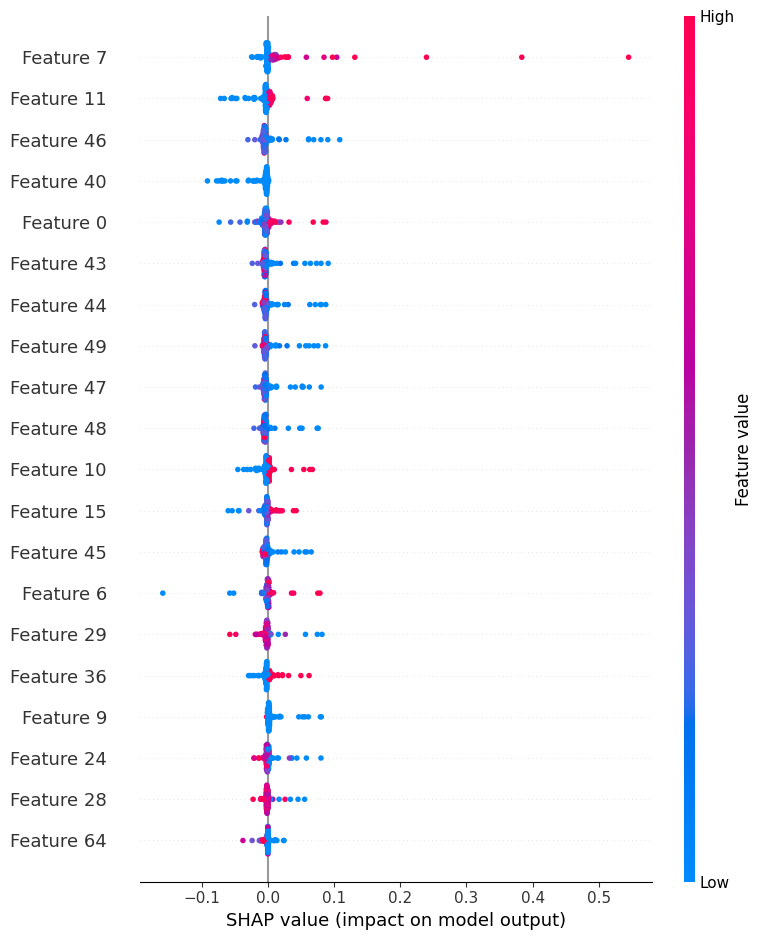

In [93]:
# For the NeuralCDE model
shap.summary_plot(shap_values, last_step_X_test)